# heom

## Introduction
critically damped bath + spin boson phase transition

## Setup

In [4]:
import contextlib
import time

import numpy as np
from matplotlib import pyplot as plt

from qutip import *


from qutip.solver.heom import (
    BosonicBath,
    DrudeLorentzBath,
    DrudeLorentzPadeBath,
    HEOMSolver,
    HSolverDL,
)

from scipy.integrate import quad
from scipy.optimize import curve_fit

%matplotlib inline

In [5]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1. / np.tan(x)

In [6]:
def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1. / np.tanh(x)

In [7]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of: (solver_result, measurement_operation,
        color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(result.times, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [8]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [9]:

def integral(function,*args,**kwargs):
    if 'x_i' not in kwargs:
          raise Exception('Missing x_i, {} instead'.format(kwargs.keys()))
    if 'x_f' not in kwargs:
          raise Exception('Missing x_f, {} instead'.format(kwargs.keys()))
    x_i = kwargs['x_i']
    x_f = kwargs['x_f']
    limit = kwargs['limit']
    def function_real(x,*args):
        return np.real(function(x,*args))
    def function_imag(x,*args):
        return np.imag(function(x,*args))
        
    

    return quad(function_real, x_i, x_f,args=args,limit=limit)[0] + 1j * quad(function_imag, x_i, x_f,args=args,limit=limit)[0]


In [10]:
#some utility functions from SUMO

def coth2(beta,x):
    if x == 0:
        raise Exception('argument should not be zero')
    if beta == 'inf':
        return sg(np.real(x))
    return (np.exp(beta*x) + np.exp(-beta*x)) / (np.exp(beta*x) - np.exp(-beta*x))


def sg(t):
    if t > 0:
        return 1
    return -1
def theta(t):
    if t < 0:
        return 0
    return 1

def compute_correlations(J,beta,W_i,W_f,integration_limit,t_corr_list):
    def to_integrate_symmetric(w,t,J,beta):
        return 1 / (np.pi) * J(w) * coth2(beta,w/2.) * np.cos(w * t)
    def to_integrate_antisymmetric(w,t,J):
        return - 1 / (np.pi) * 1j * J(w) * np.sin(w * t)
    def compute_symmetric(J,beta,W_i,W_f,integration_limit,t_corr_list):
        print('Computing symmetric correlations ({length})'.format(length="t_corr_list"))
        res = []
        for t_index in np.arange(len(t_corr_list)):
            t = t_corr_list[t_index]
            res.append(integral(to_integrate_symmetric,t,J,beta,x_i=W_i,x_f=W_f,limit=integration_limit) )
        return res
    def compute_antisymmetric(J,W_i,W_f,integration_limit,t_corr_list):
        print('Computing antisymmetric correlations ({length})'.format(length="t_corr_list"))
        res = []
        for t_index in np.arange(len(t_corr_list)):
            t = t_corr_list[t_index]
            res.append(integral(to_integrate_antisymmetric,t,J,x_i=W_i,x_f=W_f,limit=integration_limit) )
        return res
    C_s = compute_symmetric(J,beta,W_i,W_f,integration_limit,t_corr_list)
    C_as = compute_antisymmetric(J,W_i,W_f,integration_limit,t_corr_list)
    return C_s, C_as

In [11]:
# Helper functions for packing the paramters a, b and c into a single numpy
# array as required by SciPy's curve_fit:

def pack(a, b, c):
    """ Pack parameter lists for fitting. """
    return np.concatenate((a, b, c))
    

def unpack(params):
    """ Unpack parameter lists for fitting. """
    N = len(params) // 3
    a = params[:N]
    b = params[N:2 * N]
    c = params[2 * N:]
    return a, b, c

In [12]:
# Defining the system Hamiltonian
# Energy of the 2-level system.

eps = 1/10   #small system energy

Hsys =  0.5 * eps * sigmax() 


### ALPHA
#alpha = 1.2
alpha = 0.2

#BATH CUT OFF
wc = 1

t_corr_list = np.linspace(0,25,1000)

beta = np.inf
beta = 'inf'

W_i = 0
W_f = 10 * wc
integration_limit =  2000

def J(w):
    """ The Ohmic bath spectral density as a function of w (and the bath parameters). """
    return (np.pi/2)* w * alpha * 1 / (1+(w/wc)**2)**2

C_s,C_as = compute_correlations(J,beta,W_i,W_f,integration_limit,t_corr_list)

Computing symmetric correlations (t_corr_list)
Computing antisymmetric correlations (t_corr_list)


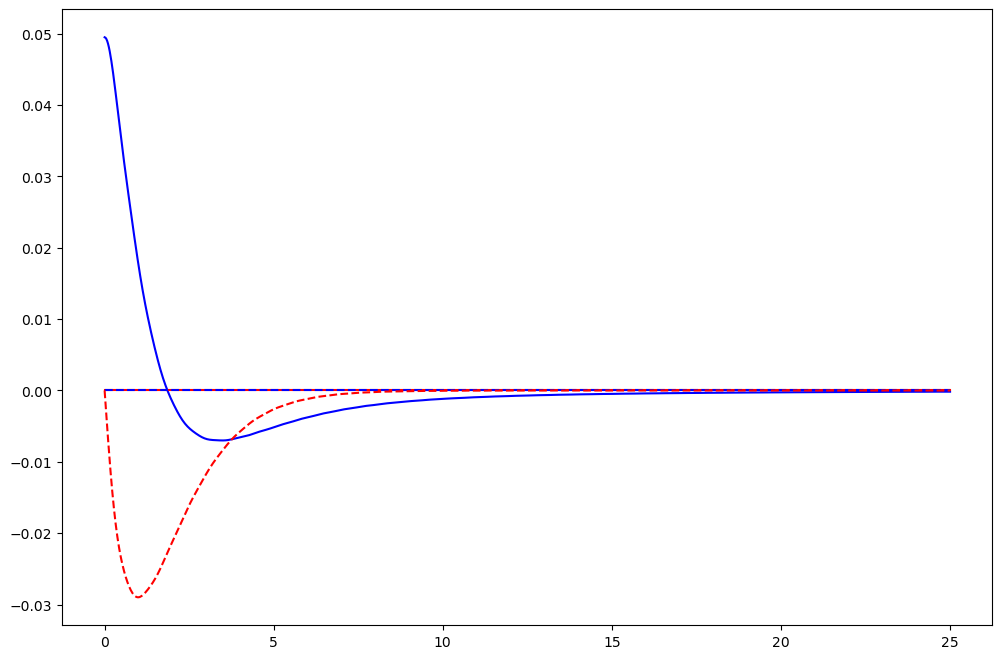

In [13]:

##################################################################
fig, axs = plt.subplots(1, 1,figsize=(12,8))

axs.plot(t_corr_list,np.real(C_s),'b',label='full mats')
axs.plot(t_corr_list,np.real(C_as),'r',label='full mats')

axs.plot(t_corr_list,np.imag(C_s),'b--',label='full mats')
axs.plot(t_corr_list,np.imag(C_as),'r--',label='full mats')



plt.show()

In [14]:
# The approximate correlation functions and a helper for fitting the approximate correlation
# function to values calculated from the analytical formula:

def correlation_approx_real(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters. """
    tot = 0
    for i in range(len(a)):
        tot += a[i] * np.exp(b[i] * t) * np.cos(c[i] * t)
    return tot      


def correlation_approx_imag(t, a, b, c):
    """ Calculate the fitted value of the function for the given parameters. """
    tot = 0
    for i in range(len(a)):
        tot += a[i] * np.exp(b[i] * t) * np.sin(c[i] * t)    
    return tot


def fit_correlation_real(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.000001] * len(t)

    C_max = abs(max(C, key=abs))

    #guesses = pack([C_max] * N, [-wc] * N, [wc] * N)
    guesses = pack([0] * N, [-wc] * N, [wc] * N)
    lower_bounds = pack([-20 * C_max] * N, [-np.inf] * N, [0.] * N)
    upper_bounds = pack([20 * C_max] * N, [0.1] * N, [np.inf] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_real(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)


def fit_correlation_imag(C, t, wc, N):
    """ Fit the spectral density with N underdamped oscillators. """
    sigma = [0.000001] * len(t)

    C_max = abs(max(C, key=abs))

    guesses = pack([-C_max] * N, [-2] * N, [1] * N)
    lower_bounds = pack([-5 * C_max] * N, [-100] * N, [0.] * N)
    upper_bounds = pack([5 * C_max] * N, [0.01] * N, [100] * N)

    params, _ = curve_fit(
        lambda x, *params: correlation_approx_imag(t, *unpack(params)),
        t, C,
        p0=guesses,
        bounds=(lower_bounds, upper_bounds),
        sigma=sigma,
        maxfev=1000000000,
    )

    return unpack(params)    

In [15]:
t = t_corr_list
#C = ohmic_correlation(t, alpha=alpha, wc=wc)

C = [C_s[kk]+C_as[kk] for kk,t in enumerate(t_corr_list)]

NfitsR = 4 #number of exps in R /I
NfitsI = 2 #number of exps in R /I


params_k_real = [
    fit_correlation_real(np.real(C), t, wc=wc, N=i+1)
    for i in range(NfitsR)
]

params_k_imag = [
    fit_correlation_imag(np.imag(C), t, wc=wc, N=i+1)
    for i in range(NfitsI)
]

Parameters [k=0]: lam=[0.05012812]; gamma=[-0.56665892]; w0=[0.79582042]


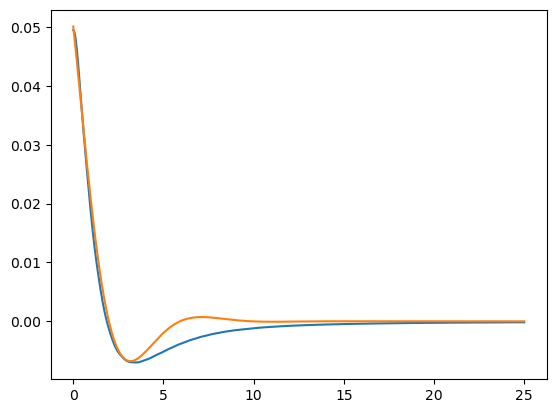

Parameters [k=1]: lam=[0.01578221 0.03467277]; gamma=[-0.23709414 -0.61669594]; w0=[0.55790224 1.08301636]


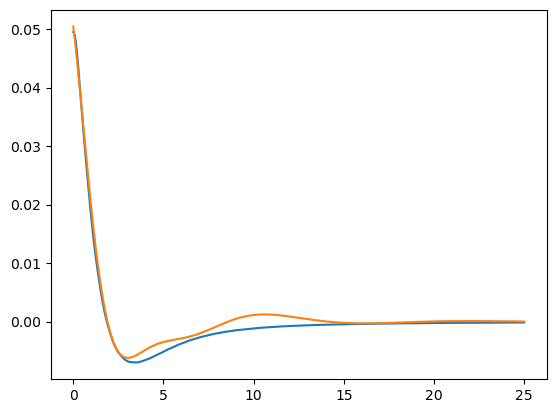

Parameters [k=2]: lam=[ 0.14438285 -0.99009901  0.89742507]; gamma=[-0.42950795 -0.84395242 -0.8934466 ]; w0=[2.09615020e-01 2.54951242e-04 2.90869491e-01]


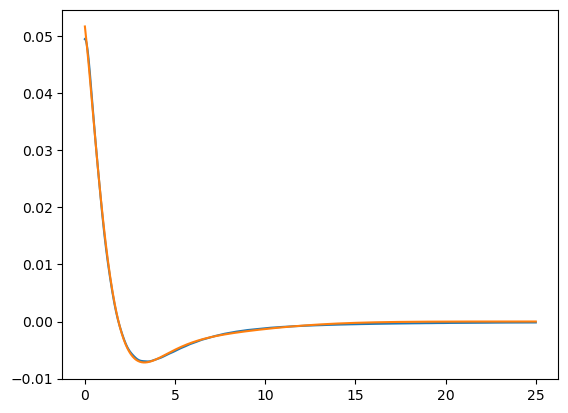

Parameters [k=3]: lam=[ 0.57665753 -0.99009901  0.01805884  0.44609434]; gamma=[-0.64933589 -0.86323293 -0.22068076 -1.10961632]; w0=[2.67062059e-01 2.71879561e-04 1.64479129e-01 4.77766173e-01]


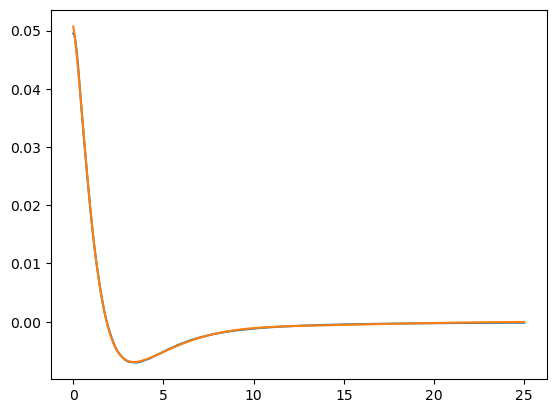

In [16]:
for k, params in enumerate(params_k_real):
    lam, gamma, w0 = params
    y = correlation_approx_real(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.real(C), t, y)
    plt.show()

Parameters [k=0]: lam=[0.05012812]; gamma=[-0.56665892]; w0=[0.79582042]


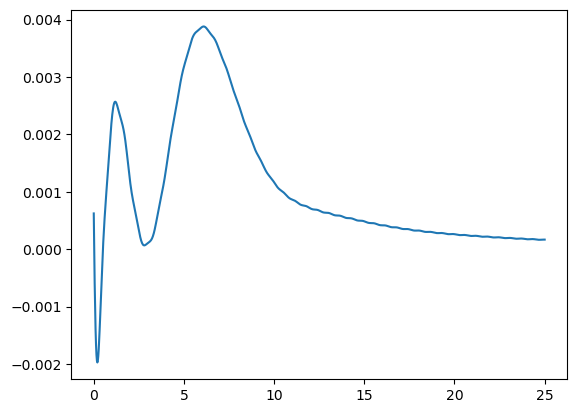

Parameters [k=1]: lam=[0.01578221 0.03467277]; gamma=[-0.23709414 -0.61669594]; w0=[0.55790224 1.08301636]


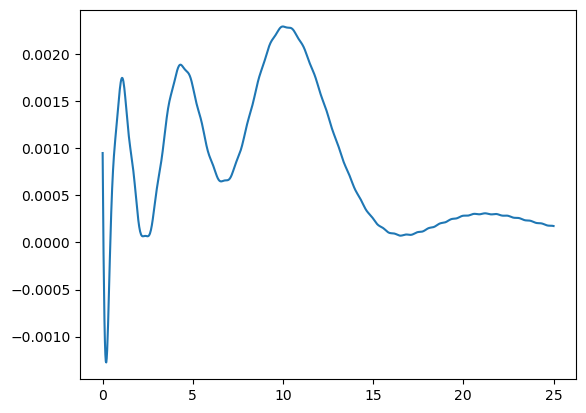

Parameters [k=2]: lam=[ 0.14438285 -0.99009901  0.89742507]; gamma=[-0.42950795 -0.84395242 -0.8934466 ]; w0=[2.09615020e-01 2.54951242e-04 2.90869491e-01]


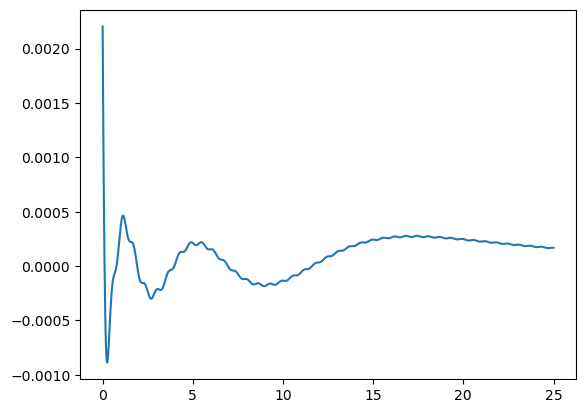

Parameters [k=3]: lam=[ 0.57665753 -0.99009901  0.01805884  0.44609434]; gamma=[-0.64933589 -0.86323293 -0.22068076 -1.10961632]; w0=[2.67062059e-01 2.71879561e-04 1.64479129e-01 4.77766173e-01]


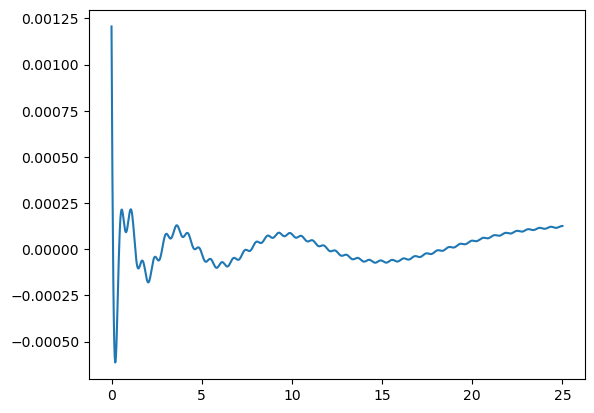

In [17]:
#error plots

for k, params in enumerate(params_k_real):
    lam, gamma, w0 = params
    y = correlation_approx_real(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, y-np.real(C))
    plt.show()

Parameters [k=0]: lam=[-0.14490448]; gamma=[-0.83238726]; w0=[0.46853463]


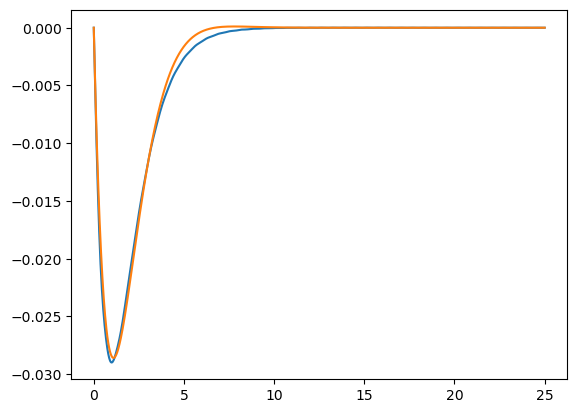

Parameters [k=1]: lam=[-0.14490448 -0.14490448]; gamma=[-0.82427669 -1.10935823]; w0=[0.2184568  0.32214668]


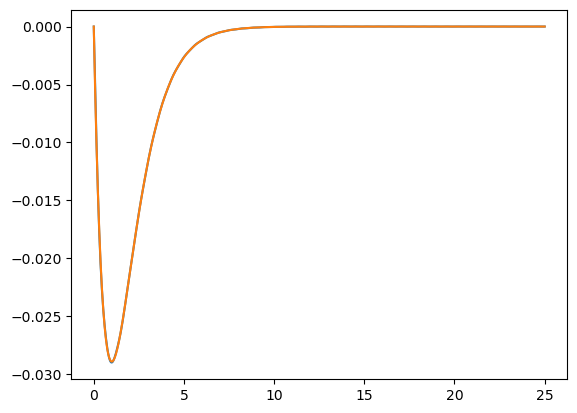

In [18]:
for k, params in enumerate(params_k_imag):
    lam, gamma, w0 = params
    y = correlation_approx_imag(t, lam, gamma, w0)
    print(f"Parameters [k={k}]: lam={lam}; gamma={gamma}; w0={w0}")
    plt.plot(t, np.imag(C), t, y)
    plt.show()

In [19]:
#these functions are badly named, just organizes the fits into appropriate lists for the heom

def matsubara_coefficients_from_corr_fit_real(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part of the correlation function """
    ckAR = [0.5 * x + 0j for x in lam]  # the 0.5 is from the cosine
    ckAR.extend(np.conjugate(ckAR))     # extend the list with the complex conjugates
    
    vkAR = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAR.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])
    
    return ckAR, vkAR

def matsubara_coefficients_from_corr_fit_imag(lam, gamma, w0):
    """ Return the matsubara coefficients for the imaginary part of the correlation function. """
    ckAI = [-0.5j * x for x in lam]  # the 0.5 is from the sine
    ckAI.extend(np.conjugate(ckAI))  # extend the list with the complex conjugates
    
    vkAI = [-x - 1.0j * y for x, y in zip(gamma, w0)]
    vkAI.extend([-x + 1.0j * y for x, y in zip(gamma, w0)])
    
    return ckAI, vkAI

In [20]:
ckAR, vkAR = matsubara_coefficients_from_corr_fit_real(*params_k_real[-1])   #-1 because 
                                                                        #we use the max number of
                                                                        #exponents tried in the 
                                                                        # fitting step
ckAI, vkAI = matsubara_coefficients_from_corr_fit_imag(*params_k_imag[-1])

In [21]:
# Initial state of the system.
rho0 = basis(2, 0) * basis(2, 0).dag()

In [22]:
# System-bath coupling 
Q = sigmaz()  # coupling operator


Ttot = 300
# Times to solve for:
tlist = np.linspace(0, Ttot, 1000)

### Solving for the dynamics as a function of time:

Having created the lists which specify the bath correlation functions, we create a `BosonicBath` from them and pass the bath to the `HEOMSolver` class.

The solver constructs the "right hand side" (RHS) determinining how the system and auxiliary density operators evolve in time. This can then be used to solve for dynamics or steady-state.

Below we create the bath and solver and then solve for the dynamics by calling `.run(rho0, tlist)`.

In [23]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 5  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc5 = HEOMMats.run(rho0, tlist)

/home/neill/anaconda3/envs/qutip5anim/lib/python3.11/site-packages/qutip-5.0.0.dev0+nogit-py3.11-linux-x86_64.egg/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


RHS construction time: 0.2741658687591553
10.0%. Run time:   6.79s. Est. time left: 00:00:01:01
20.0%. Run time:  13.61s. Est. time left: 00:00:00:54
30.0%. Run time:  20.32s. Est. time left: 00:00:00:47
40.0%. Run time:  27.39s. Est. time left: 00:00:00:41
50.1%. Run time:  34.48s. Est. time left: 00:00:00:34
60.1%. Run time:  41.32s. Est. time left: 00:00:00:27
70.1%. Run time:  48.16s. Est. time left: 00:00:00:20
80.1%. Run time:  55.19s. Est. time left: 00:00:00:13
90.1%. Run time:  62.02s. Est. time left: 00:00:00:06
100.0%. Run time:  68.91s. Est. time left: 00:00:00:00
Total run time:  68.91s
ODE solver time: 68.9143385887146


In [38]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 5  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc5 = HEOMMats.run(rho0, tlist)
    
NC = 6  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc6 = HEOMMats.run(rho0, tlist)
    
NC = 7  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc7 = HEOMMats.run(rho0, tlist)

    
#this one is a bit slow.... not sure how much further i can push this
NC = 8  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc8 = HEOMMats.run(rho0, tlist)
    
NC = 9  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc9 = HEOMMats.run(rho0, tlist)

RHS construction time: 1.2076184749603271
ODE solver time: 81.36460709571838
RHS construction time: 3.4627835750579834
ODE solver time: 30.171618938446045
RHS construction time: 8.85059666633606
ODE solver time: 279.1682186126709
RHS construction time: 22.372890949249268
ODE solver time: 804.3989470005035


RHS construction time: 49.32694053649902
ODE solver time: 2248.2531068325043


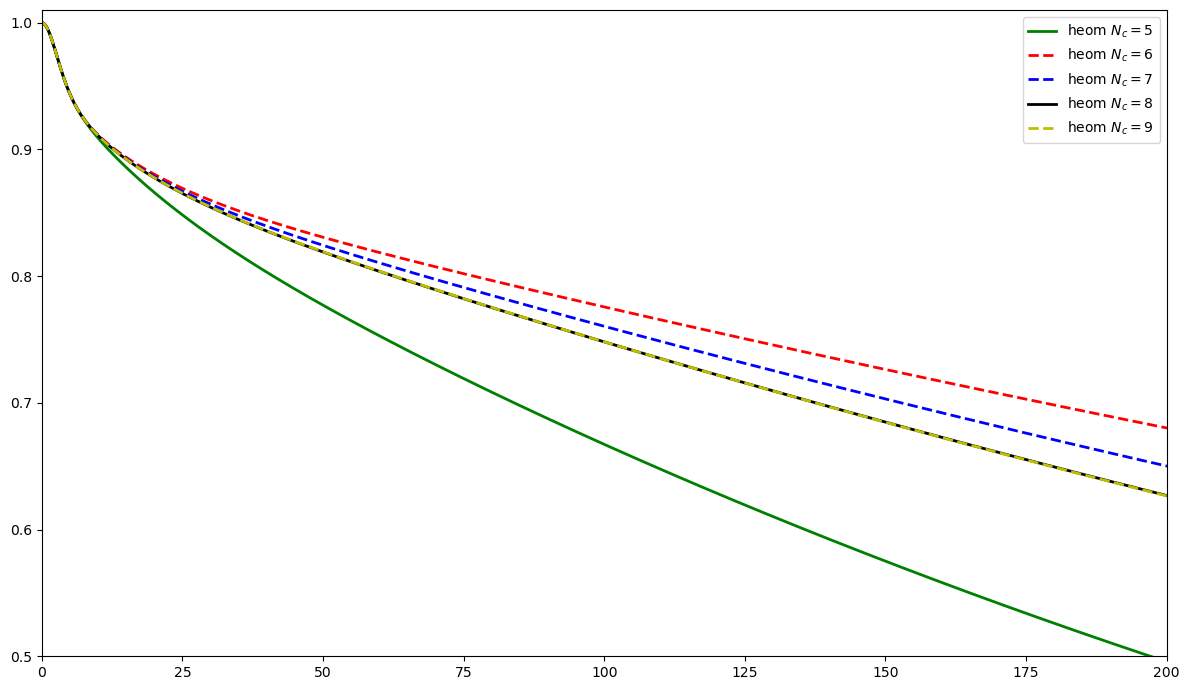

In [65]:
#alpha = 0.75 @ 4 R, 2 I
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    (resultMatsnc5, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc6, sigmaz(), 'r--', "heom $N_c=6$"),
    (resultMatsnc7, sigmaz(), 'b--', "heom $N_c=7$"),
    (resultMatsnc8, sigmaz(), 'k', "heom $N_c=8$"),
    (resultMatsnc9, sigmaz(), 'y--', "heom $N_c=9$"),
], axes=axes)


#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
axes.set_ylim(0.5,1.01)
axes.set_xlim(0,200)
axes.legend(loc=0)

fig.tight_layout()

In [55]:
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)
# Number of levels of the hierarchy to retain:
NC = 5  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc5a1p2 = HEOMMats.run(rho0, tlist)
    
NC = 6  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc6a1p2 = HEOMMats.run(rho0, tlist)
    
NC = 7  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc7a1p2 = HEOMMats.run(rho0, tlist)

    
#this one is a bit slow.... not sure how much further i can push this
NC = 8  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc8a1p2 = HEOMMats.run(rho0, tlist)
    
NC = 9  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc9a1p2 = HEOMMats.run(rho0, tlist)

RHS construction time: 1.5422582626342773
ODE solver time: 103.70818901062012
RHS construction time: 4.690242290496826
ODE solver time: 113.18515014648438
RHS construction time: 14.194144010543823
ODE solver time: 222.7655894756317
RHS construction time: 38.19268751144409
ODE solver time: 1715.7227528095245
RHS construction time: 92.31397414207458
ODE solver time: 12673.68163895607


In [75]:
NC = 10  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc10a1p2 = HEOMMats.run(rho0, tlist)

RHS construction time: 220.55653262138367
ODE solver time: 16312.107627868652


In [79]:
NC = 11  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):
    resultMatsnc11a1p2 = HEOMMats.run(rho0, tlist)

RHS construction time: 503.70587491989136
ODE solver time: 14405.54762506485


In [ ]:
NC = 11  #this is an importance covnergence parameter
with timer("RHS construction time"):
    bath = BosonicBath(Q, ckAR, vkAR, ckAI, vkAI)

    HEOMMats = HEOMSolver(Hsys, [bath], NC, options=options)

with timer("ODE solver time"):

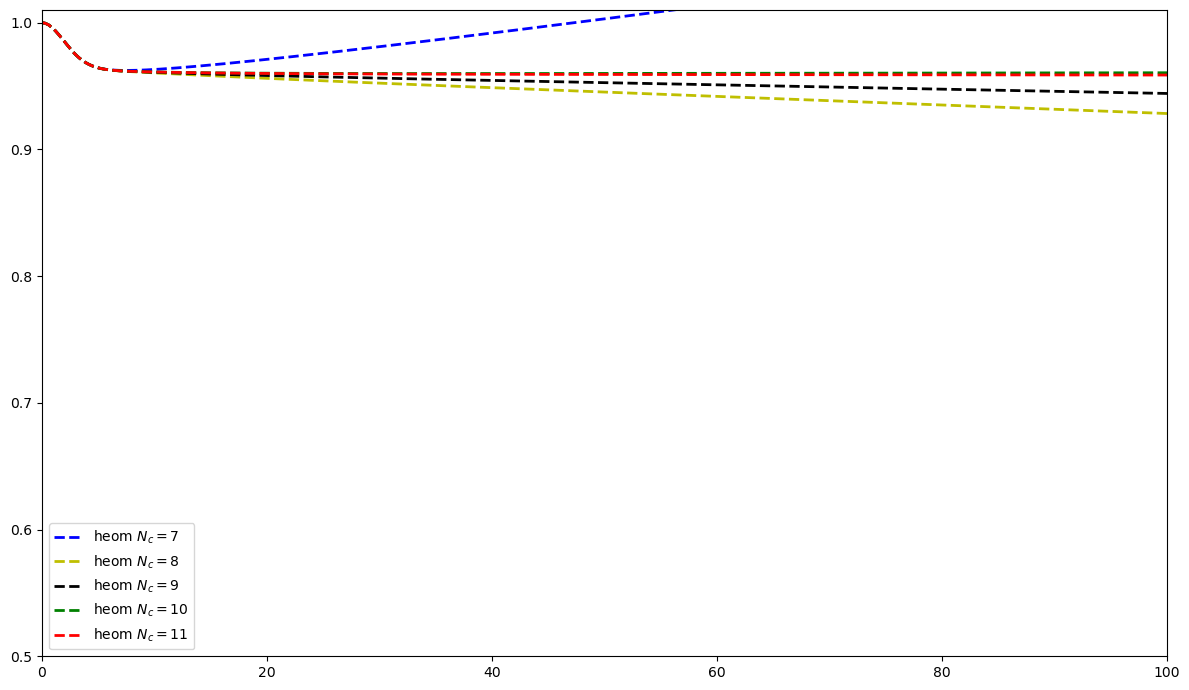

In [80]:
#alpha = 0.75 @ 4 R, 2 I
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    #(resultMatsnc5a1p2, sigmaz(), 'g', "heom $N_c=5$"),
    #(resultMatsnc6a1p2, sigmaz(), 'r--', "heom $N_c=6$"),
    (resultMatsnc7a1p2, sigmaz(), 'b--', "heom $N_c=7$"),
    (resultMatsnc8a1p2, sigmaz(), 'y--', "heom $N_c=8$"),
    (resultMatsnc9a1p2, sigmaz(), 'k--', "heom $N_c=9$"),
    (resultMatsnc10a1p2, sigmaz(), 'g--', "heom $N_c=10$"),
    (resultMatsnc11a1p2, sigmaz(), 'r--', "heom $N_c=11$"),
], axes=axes)


#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
axes.set_ylim(0.5,1.01)
axes.set_xlim(0,100)
axes.legend(loc=0)

fig.tight_layout()

In [71]:
expect(resultMatsnc8a1p2.states
       ,sigmaz())

array([1.        +0.00000000e+00j, 0.99955311+0.00000000e+00j,
       0.99825669+0.00000000e+00j, 0.99622497+0.00000000e+00j,
       0.99360999+0.00000000e+00j, 0.99057974+0.00000000e+00j,
       0.98730616+0.00000000e+00j, 0.98395557+0.00000000e+00j,
       0.9806777 +0.00000000e+00j, 0.97759495+0.00000000e+00j,
       0.97479502+0.00000000e+00j, 0.97232891+3.33557466e-14j,
       0.97021429+2.34052111e-13j, 0.96844232+7.51026740e-13j,
       0.96698586+1.91418138e-12j, 0.96580721+4.04755645e-12j,
       0.96486452+7.42882014e-12j, 0.96411627+1.30160288e-11j,
       0.96352414+2.32606280e-11j, 0.96305456+4.03576827e-11j,
       0.96267913+6.37788159e-11j, 0.96237465+9.05563729e-11j,
       0.96212256+1.17396913e-10j, 0.9619084 +1.42252228e-10j,
       0.96172112+1.64569545e-10j, 0.96155242+1.84759936e-10j,
       0.96139624+2.03493769e-10j, 0.9612482 +2.21267614e-10j,
       0.96110526+2.38293157e-10j, 0.96096533+2.54420659e-10j,
       0.96082705+2.69151994e-10j, 0.96068957+2.8191796

In [78]:
import pickle
pickle_out = open("heom.dat",'wb')
saved_dict = {}
saved_dict['tlist'] = tlist
saved_dict['resultMatsnc8a1p2'] = expect(resultMatsnc8a1p2.states
       ,sigmaz())
saved_dict['resultMatsnc9a1p2'] = expect(resultMatsnc9a1p2.states
       ,sigmaz())
saved_dict['resultMatsnc10a1p2'] = expect(resultMatsnc10a1p2.states
       ,sigmaz())
saved_dict['resultMatsnc8a0p75'] = expect(resultMatsnc8.states
       ,sigmaz())
saved_dict['resultMatsnc9a0p75'] = expect(resultMatsnc9.states
       ,sigmaz())

pickle.dump(saved_dict,pickle_out)
pickle_out.close()

In [73]:
pickle_in = open("heom.dat",'rb')
pfdata = pickle.load(pickle_in)
pickle_in.close()

In [74]:
pfdata

{'tlist': array([  0.        ,   0.3003003 ,   0.6006006 ,   0.9009009 ,
          1.2012012 ,   1.5015015 ,   1.8018018 ,   2.1021021 ,
          2.4024024 ,   2.7027027 ,   3.003003  ,   3.3033033 ,
          3.6036036 ,   3.9039039 ,   4.2042042 ,   4.5045045 ,
          4.8048048 ,   5.10510511,   5.40540541,   5.70570571,
          6.00600601,   6.30630631,   6.60660661,   6.90690691,
          7.20720721,   7.50750751,   7.80780781,   8.10810811,
          8.40840841,   8.70870871,   9.00900901,   9.30930931,
          9.60960961,   9.90990991,  10.21021021,  10.51051051,
         10.81081081,  11.11111111,  11.41141141,  11.71171171,
         12.01201201,  12.31231231,  12.61261261,  12.91291291,
         13.21321321,  13.51351351,  13.81381381,  14.11411411,
         14.41441441,  14.71471471,  15.01501502,  15.31531532,
         15.61561562,  15.91591592,  16.21621622,  16.51651652,
         16.81681682,  17.11711712,  17.41741742,  17.71771772,
         18.01801802,  18.31831

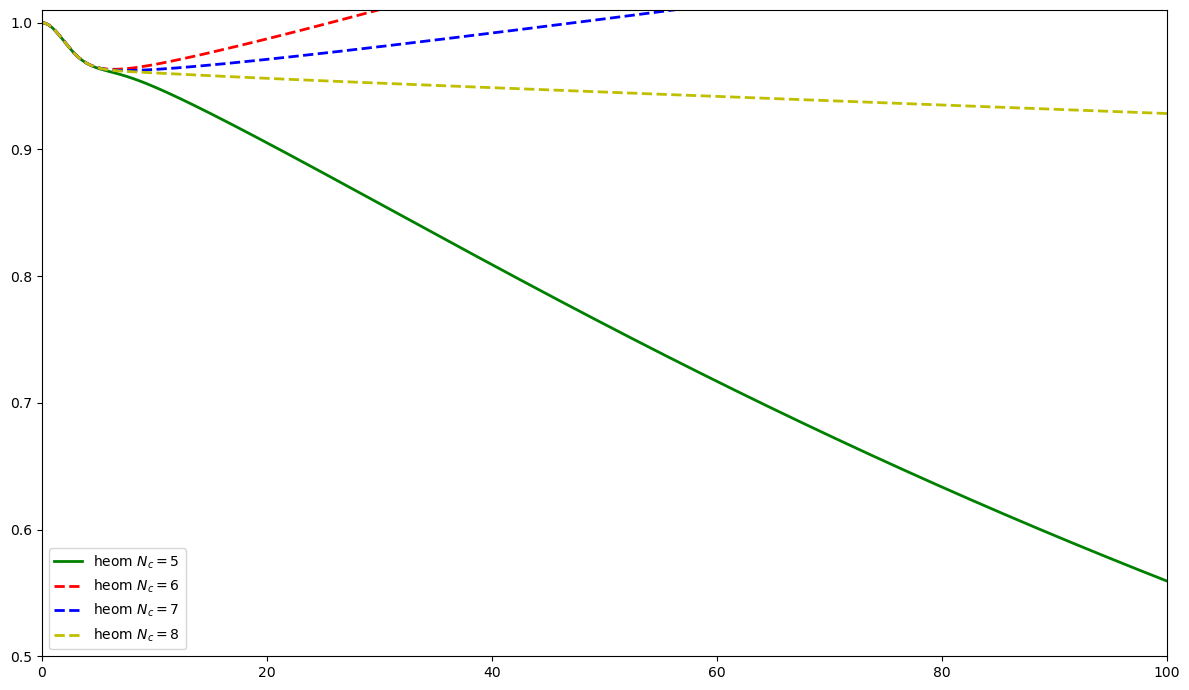

In [126]:
#An example for:
#alpha = 1.2 @ 4 R, 2 I
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    (resultMatsnc5, sigmaz(), 'g', "heom $N_c=5$"),
    (resultMatsnc6, sigmaz(), 'r--', "heom $N_c=6$"),
    (resultMatsnc7, sigmaz(), 'b--', "heom $N_c=7$"),
    (resultMatsnc8, sigmaz(), 'y--', "heom $N_c=8$"),
], axes=axes)


#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
axes.set_ylim(0.5,1.01)
axes.set_xlim(0,100)
axes.legend(loc=0)

fig.tight_layout()

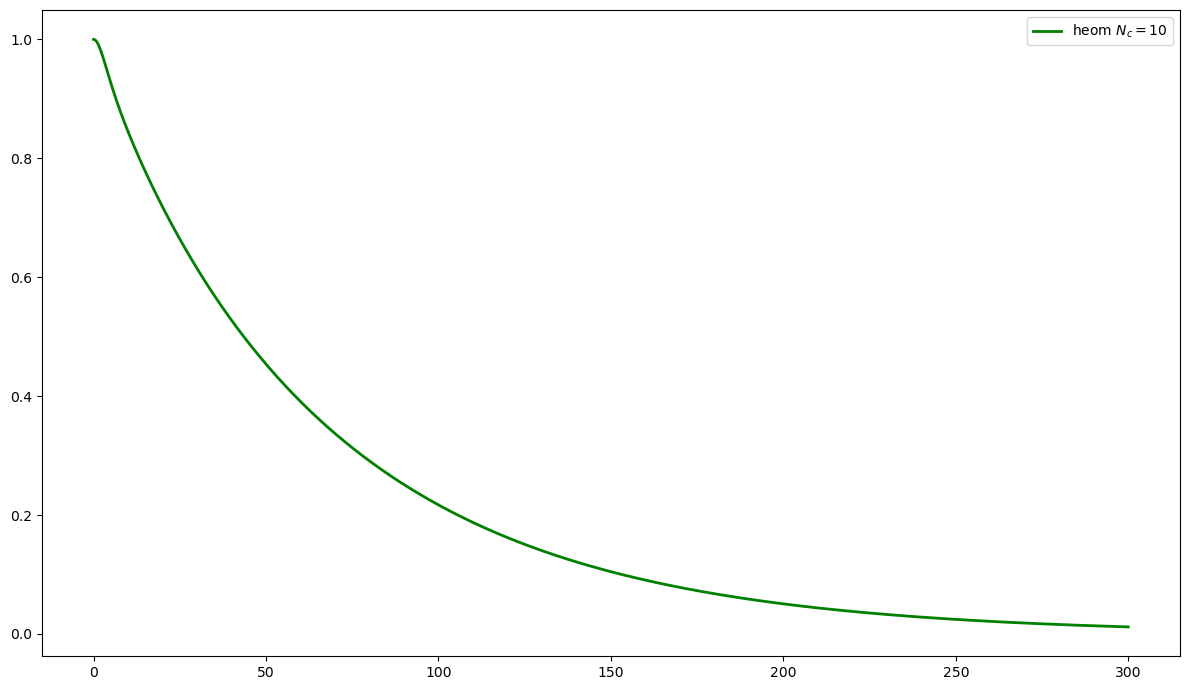

In [88]:

#An example for:
#alpha = 0.5
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(12, 7))


plot_result_expectations([    
    (resultMatsnc5, sigmaz(), 'g', "heom $N_c=5$"),   
], axes=axes)


#axes.locator_params(axis='y', nbins=8)
#axes.locator_params(axis='x', nbins=8)
#axes.set_ylim(-1,2)
#axes.set_xlim(0,20)
axes.legend(loc=0)

fig.tight_layout()